In [30]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer.primitives import Sampler
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_distribution
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate, UnitaryGate, GroverOperator, MCMT, ZGate
import qiskit.quantum_info as qi
import galois

## Grover's Algorithm

### Problem

The problem is stated as follows. Suppose we have a function $f: \Sigma^n \to \Sigma$. What is a string $x \in \Sigma^n$ such that $f(x) = 1$?

This is referred to as the unstructured search problem, as we are effectively searching for a particular element in an list without any prior notion of structure pertaining to the function of interest. While classical approaches for searching through an unsorted list can only achieve a complexity of $O(n)$, Grover's Algorithm, as we will soon describe, is capable of achieving a quadratic speedup, producing a complexity of $O(\sqrt n)$.

### Algorithm

Grover's algorithm proceeds as follows:

1. Initialize $n$-qubit register $Q$ to state $|0^n\rangle$ and then apply a Hadamard to each qubit in $Q$.

2. Apply $t$ times the unitary Grover operation $G = H^{\otimes n}Z_\text{OR}H^{\otimes n}Z_f$ to $Q$.

3. Measure $Q$ in standard basis and output string.

### Implementation

In [60]:
def grover_oracle(marked_states):
    num_qubits = len(marked_states[0])
    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        rev_target = target[::-1]
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

def grover(marked_states, num_iter):
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])
    qc = QuantumCircuit(num_qubits, num_qubits)
    qc.h(range(num_qubits))
    for _ in range(num_iter):
        qc.compose(GroverOperator(grover_oracle(marked_states)),
              inplace=True)
    qc.measure(range(num_qubits), range(num_qubits))
    return qc

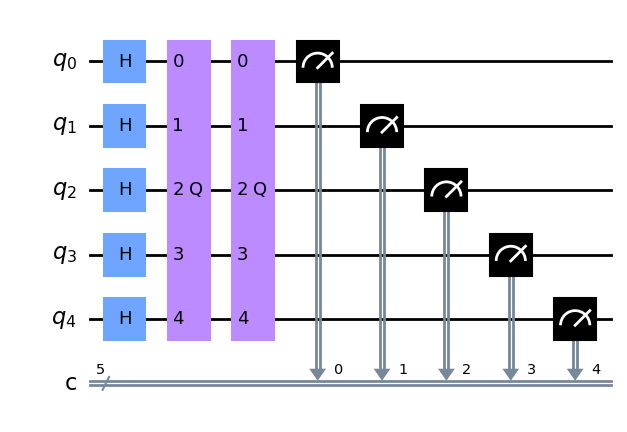

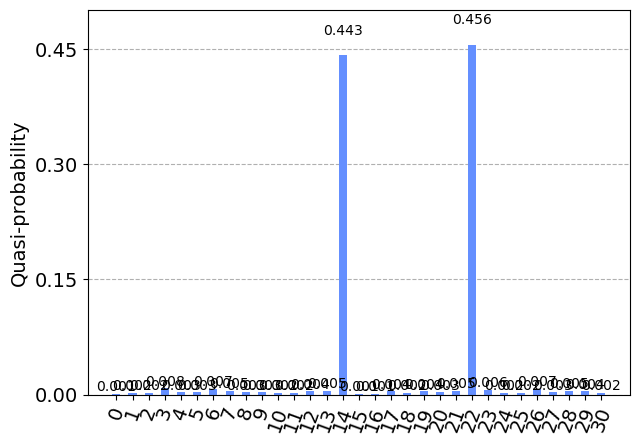

In [82]:
qc = grover(['10110', '01110'], 2)
display(qc.draw('mpl'))
result = Sampler().run(qc, shots=1000).result()
display(plot_histogram(result.quasi_dists))